<a href="https://colab.research.google.com/github/binliu0630/transformers/blob/master/STS_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries required

In [3]:
!pip install transformers hdbscan pacmap

     |████████████████████████████████| 2.3MB 3.9MB/s 
     |████████████████████████████████| 6.4MB 42.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 43.9MB/s 
     |████████████████████████████████| 901kB 40.9MB/s 
     |████████████████████████████████| 655kB 30.1MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311710 sha256=2ffe2b2502c202ef2729a83afe2151c0f0d47a10621286ac76462f6009f4520f
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391611 sha256=b9eba85cf673e850a7fd02a4d2c340e45bb5257a4dd88a8006e7419fcb4db131
  Stored in directory: /root/.cache/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
Successfully built annoy


# Download dataset

In [4]:
!wget https://s3-us-west-2.amazonaws.com/ai2-website/data/ARC-V1-Feb2018.zip

--2021-06-14 18:49:58--  https://s3-us-west-2.amazonaws.com/ai2-website/data/ARC-V1-Feb2018.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.129.24
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.129.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 680841265 (649M) [application/zip]
Saving to: ‘ARC-V1-Feb2018.zip’

ARC-V1-Feb2018.zip  100%[===================>] 649.30M  33.3MB/s    in 20s     

2021-06-14 18:50:19 (32.1 MB/s) - ‘ARC-V1-Feb2018.zip’ saved [680841265/680841265]



In [5]:
from zipfile import ZipFile

with ZipFile('ARC-V1-Feb2018.zip', "r") as zip_obj:
    zip_obj.extractall("data")    

# Import dataset into Pandas

In [59]:
import pandas as pd
import numpy as np

df = pd.read_csv("./data/ARC-V1-Feb2018-2/ARC-Easy/ARC-Easy-Train.csv")

In [7]:
df.head()

,questionID,originalQuestionID,totalPossiblePoint,AnswerKey,isMultipleChoiceQuestion,includesDiagram,examName,schoolGrade,year,question,subject,category
0,Mercury_7220990,7220990,1,B,1,0,Mercury,8,2015,Which factor will most likely cause a person t...,NaN,Train
1,MCAS_2007_8_5189,5189,1,B,1,0,MCAS,8,2007,Lichens are symbiotic organisms made of green ...,NaN,Train
2,Mercury_SC_401169,401169,1,D,1,0,Mercury,5,2015,When a switch is used in an electrical circuit...,NaN,Train
3,MCAS_2004_8_27,27,1,A,1,0,MCAS,8,2004,Which of the following is an example of an ass...,NaN,Train
4,NYSEDREGENTS_2006_8_10,10,1,3,1,0,NYSEDREGENTS,8,2006,"Rocks are classified as igneous, metamorphic, ...",NaN,Train


In [60]:
df = df[df.question.str.contains('\?')]
df.question = [s.split('?')[0] + '?' for s in df.question]

In [61]:
df['question'][1]

'Lichens are symbiotic organisms made of green algae and fungi. What do the green algae supply to the fungi in this symbiotic relationship?'

# Load transformer model

In [10]:
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from itertools import zip_longest
import torch


def grouper(iterable, n, fillvalue=None):
    """Taken from: https://docs.python.org/3/library/itertools.html#itertools-recipes"""
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)


def mean_pooling(model_output, attention_mask):
    """
    Mean pooling to get sentence embeddings. See:
    https://huggingface.co/sentence-transformers/paraphrase-distilroberta-base-v1
    """
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) # Sum columns
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Sentences to embed
df = df[df.question.str.contains('\?')]
df.question = [s.split('?')[0] + '?' for s in df.question]

# Fetch the model & tokenizer from transformers library
model_name = 'sentence-transformers/stsb-roberta-large'
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [70]:
df['question'][1]

'Lichens are symbiotic organisms made of green algae and fungi. What do the green algae supply to the fungi in this symbiotic relationship?'

In [71]:
df = df.head(16)

In [74]:
sentence_embeddings = []
token_embeddings = []
for sentences in tqdm(grouper(df.question.tolist(), 4, None)):
  print(sentences)
  valid_sentences = [s for s in sentences if s]
  print(valid_sentences)
  encoded_input = tokenizer(valid_sentences, padding=True, truncation=True, max_length=512, return_tensors="pt")
  print(encoded_input)
  print(encoded_input['input_ids'].shape)
  model_output = model(**encoded_input)
  for i, sentence in enumerate(valid_sentences):
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][i])
        embeddings = model_output[0][i]
        token_embeddings.append(
            [{"token": token, "embedding": embedding.detach().numpy()} for token, embedding in zip(tokens, embeddings)]
        )
  sentence_embeddings.extend(
        mean_pooling(model_output, encoded_input['attention_mask']).detach().numpy()
    )
  # print(sentence_embeddings[0].shape)

0it [00:00, ?it/s]

('Which factor will most likely cause a person to develop a fever?', 'Lichens are symbiotic organisms made of green algae and fungi. What do the green algae supply to the fungi in this symbiotic relationship?', 'Which of the following is an example of an assistive device?', 'Which two body systems are directly involved in movement?')
['Which factor will most likely cause a person to develop a fever?', 'Lichens are symbiotic organisms made of green algae and fungi. What do the green algae supply to the fungi in this symbiotic relationship?', 'Which of the following is an example of an assistive device?', 'Which two body systems are directly involved in movement?']
{'input_ids': tensor([[    0, 32251,  3724,    40,   144,   533,  1303,    10,   621,     7,
          2179,    10, 11696,   116,     2,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    0, 47316, 27859,    32, 39835, 26842, 28340,   156,     9,  227

1it [00:01,  1.78s/it]

('Which change in the state of water particles causes the particles to become arranged in a fixed position?', "Earth's core is primarily composed of which of the following materials?", 'Which of the following events during meiosis contributes most to the variation within a species?', 'Which of the following was probably most important in the formation of dark, fertile soil that is good for farming?')
['Which change in the state of water particles causes the particles to become arranged in a fixed position?', "Earth's core is primarily composed of which of the following materials?", 'Which of the following events during meiosis contributes most to the variation within a species?', 'Which of the following was probably most important in the formation of dark, fertile soil that is good for farming?']
{'input_ids': tensor([[    0, 32251,   464,    11,     5,   194,     9,   514, 16710,  4685,
             5, 16710,     7,   555, 12121,    11,    10,  4460,   737,   116,
             2,     

2it [00:03,  1.70s/it]

('When igneous rock is changed into metamorphic rock, which form of energy is this process?', 'Which of these items contains only a solution?', 'Many natural rock formations change color over time. In Utah, for example, iron oxidized and formed red, orange, and yellow rock. Which of the following is the cause of this change?', 'A population of small, plant-eating beetles lives in a forest. About half of the beetles are light brown and the others are dark green. If years of drought cause the area to become dry with few trees, what would the beetle population most likely look like after several generations?')
['When igneous rock is changed into metamorphic rock, which form of energy is this process?', 'Which of these items contains only a solution?', 'Many natural rock formations change color over time. In Utah, for example, iron oxidized and formed red, orange, and yellow rock. Which of the following is the cause of this change?', 'A population of small, plant-eating beetles lives in a 

3it [00:06,  2.15s/it]

('A student in an empty classroom shouts, "Hello!" Which best explains what the student hears after the shout?', 'Which type of energy in gasoline is transformed into mechanical energy in a motorcycle engine?', 'A student standing near a campfire feels warmer as the fire grows. Which process most likely transfers heat from the campfire to the student?', 'In snapdragon plants, red flowers are dominant to white flowers. When red-flowered plants are crossed with white-flowered plants, pink flowers are produced. If a researcher wants to produce plants with only white flowers, what color should the parent plants be?')
['A student in an empty classroom shouts, "Hello!" Which best explains what the student hears after the shout?', 'Which type of energy in gasoline is transformed into mechanical energy in a motorcycle engine?', 'A student standing near a campfire feels warmer as the fire grows. Which process most likely transfers heat from the campfire to the student?', 'In snapdragon plants, 

4it [00:09,  2.39s/it]


In [75]:
len(sentence_embeddings)

16

In [76]:
sentence_embeddings

[array([-0.4477065 ,  0.71602386, -0.08017238, ...,  0.8252321 ,
         0.56503147,  0.71291125], dtype=float32),
 array([ 0.55611193,  0.5844422 , -0.54391986, ...,  0.5736011 ,
         0.42604303,  0.9506643 ], dtype=float32),
 array([-0.0919305 ,  0.11730175,  0.10387384, ...,  0.39594558,
        -1.515756  , -0.3037383 ], dtype=float32),
 array([-0.53840107,  0.31458017,  1.1253765 , ..., -0.47968602,
         0.43512097,  0.32432178], dtype=float32),
 array([-0.82878995, -0.76609564, -0.09585988, ...,  0.98848486,
        -1.8627447 ,  1.1870753 ], dtype=float32),
 array([-0.56565136, -0.7276341 ,  0.05228284, ...,  0.6181675 ,
        -1.0438259 , -0.04364288], dtype=float32),
 array([1.0091257 , 0.12451892, 0.15007703, ..., 1.6191913 , 0.16468999,
        0.84287846], dtype=float32),
 array([-0.02029501,  0.672025  , -0.33238837, ...,  0.9776604 ,
        -1.0567255 ,  0.7480262 ], dtype=float32),
 array([ 0.34382564,  0.25584218,  1.140908  , ..., -0.82660544,
        -1.83

# Create sentence embeddings

In [ ]:
sentence_embeddings = []
token_embeddings = []

# Embed 8 sentences at a time
for sentences in tqdm(grouper(df.question.tolist(), 8, None)):
    print(sentences)
    # Ignore sentences with None
    valid_sentences = [s for s in sentences if s]

    # Tokenize input
    encoded_input = tokenizer(valid_sentences, padding=True, truncation=True, max_length=512, return_tensors="pt")    

    # Create word embeddings
    model_output = model(**encoded_input)

    # For each sentence, store a list of token embeddings; i.e. a 1024-dimensional vector for each token
    for i, sentence in enumerate(valid_sentences):
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][i])
        embeddings = model_output[0][i]
        token_embeddings.append(
            [{"token": token, "embedding": embedding.detach().numpy()} for token, embedding in zip(tokens, embeddings)]
        )    

    # Pool to get sentence embeddings; i.e. generate one 1024 vector for the entire sentence
    sentence_embeddings.append(
        mean_pooling(model_output, encoded_input['attention_mask']).detach().numpy()
    )
    
# Concatenate all of the embeddings into one numpy array of shape (n_sentences, 1024)
sentence_embeddings = np.concatenate(sentence_embeddings)

In [18]:
len(sentence_embeddings)

168

In [77]:
from sklearn.preprocessing import normalize
norm_data = normalize(sentence_embeddings, norm='l2')


In [82]:
len(sentence_embeddings)

16

In [79]:
norm_data.shape

(16, 1024)

In [83]:
QUERY_ID = 0
scores = np.dot(norm_data, norm_data[QUERY_ID].T)
MATCH_ID = np.argsort(scores)[-2]

In [84]:
MATCH_ID

14

# Perform Search & Show Search Context

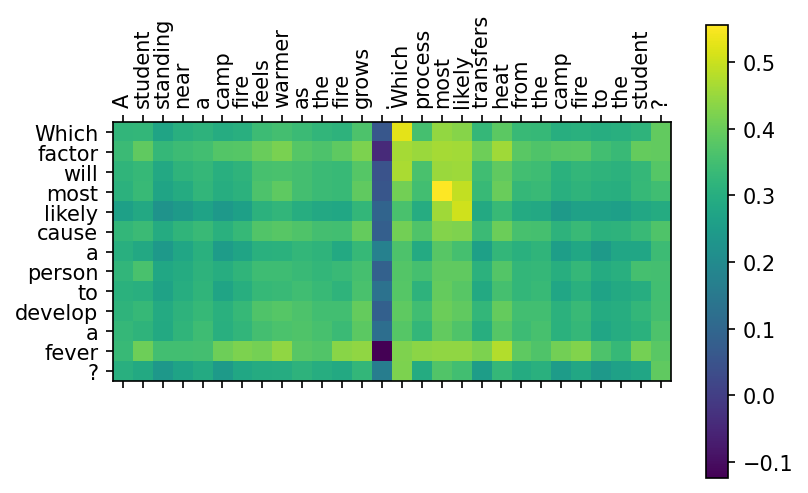

In [85]:
from IPython.core.display import display, HTML
from sklearn.preprocessing import normalize
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# # Noralize the data
# norm_data = normalize(sentence_embeddings, norm='l2')

# # Set QUERY & BEST MATCH IDs
# QUERY_ID = 0
# scores = np.dot(norm_data, norm_data[QUERY_ID].T)
# MATCH_ID = np.argsort(scores)[-2]


def get_token_embeddings(embeddings_word):
    """Returns a list of tokens and list of embeddings"""
    tokens, embeddings = [], []
    for word in embeddings_word:
        if word['token'] not in ['<s>', '<pad>', '</pad>', '</s>']:
            tokens.append(word['token'].replace('Ġ', ''))
            embeddings.append(word['embedding'])    
    return tokens, normalize(embeddings, norm='l2')

# Get tokens & token embeddings
query_tokens, query_token_embeddings = get_token_embeddings(token_embeddings[QUERY_ID])
match_tokens, match_token_embeddings = get_token_embeddings(token_embeddings[MATCH_ID])

# Calculate cosine similarity between all tokens in query and match sentences
attention = (query_token_embeddings @ match_token_embeddings.T)

def plot_attention(src, trg, attention):
    """Plot 2D plot of cosine similarities"""
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attention, interpolation='nearest')
    clb = fig.colorbar(cax)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + src, rotation=90)
    ax.set_yticklabels([''] + trg) 
    

plot_attention(match_tokens, query_tokens, attention)

In [ ]:
lengths_query

array([31.789795, 31.70999 , 31.7887  , 31.811132, 31.831669, 31.8176  ,
       31.872398, 31.823124, 31.841738, 31.825384, 31.84016 , 31.65322 ,
       31.862818], dtype=float32)

In [ ]:
attention.shape

(13, 14)

In [20]:
pip install -U sentence-transformers

     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 1.2MB 13.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=ea7cf63ac5f30f517c901ffcc8f4cc0e67b98e27b79c79ff63b851c01c88cc1a
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers


In [22]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-mpnet-base-v2 ')
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']
sentence_embeddings = model.encode(sentences)

print("Sentence embeddings:")
print(sentence_embeddings)

Exception when trying to download http://sbert.net/models/paraphrase-mpnet-base-v2 .zip. Response 403


HTTPError: ignored